In [1]:
import json
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import pipeline
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 1: Load the data from JSON
with open('results4.json', 'r') as json_file:
    data = json.load(json_file)

In [4]:
# Initialize lists to store existing and generated texts
existing_texts = []
generated_texts = []

In [9]:
# Step 2: Define Evaluation Metrics
bleu_scores = []
x_labels = []
for entry in data:
    reference = entry['existing_text']
    generated = entry['generated_text1']
    reference_tokens = nltk.word_tokenize(reference.lower())
    generated_tokens = nltk.word_tokenize(generated.lower())
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)
    bleu_scores.append(bleu_score)
    x_labels.append(f"Author {len(x_labels) + 1}")

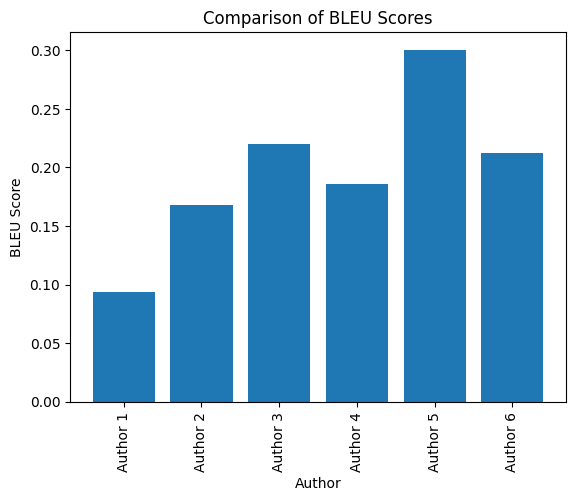

In [10]:
# Step 3: Visualize the results
plt.bar(x_labels, bleu_scores)
plt.xlabel("Author")
plt.ylabel("BLEU Score")
plt.title("Comparison of BLEU Scores")
plt.xticks(rotation=90)
plt.show()

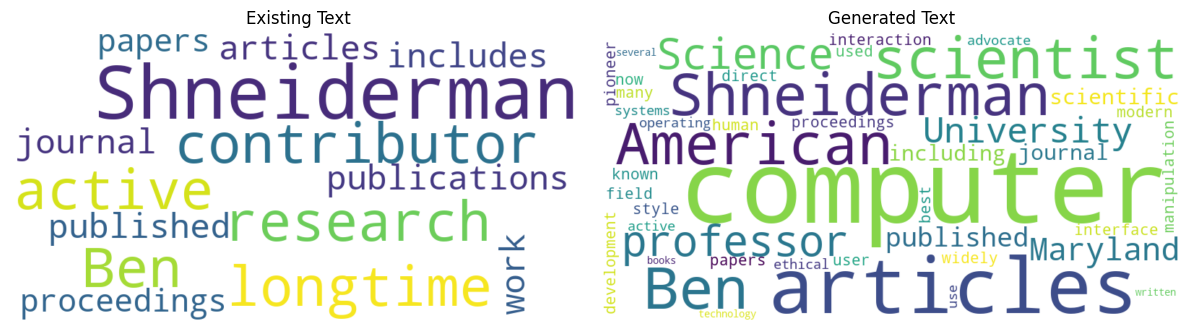

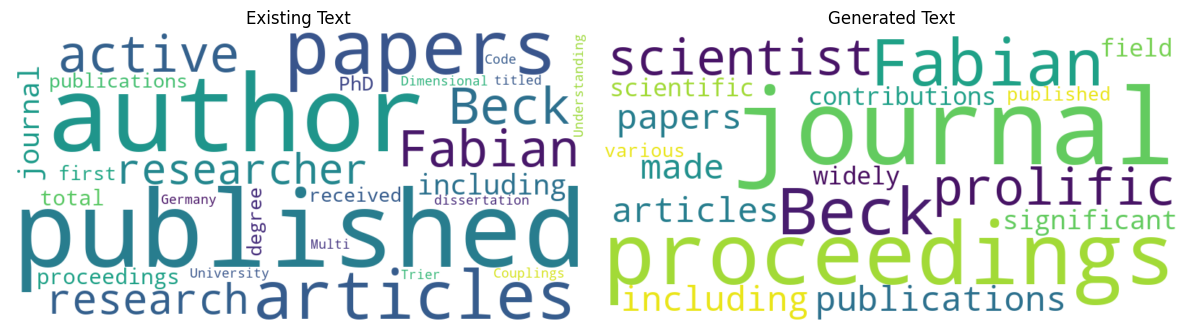

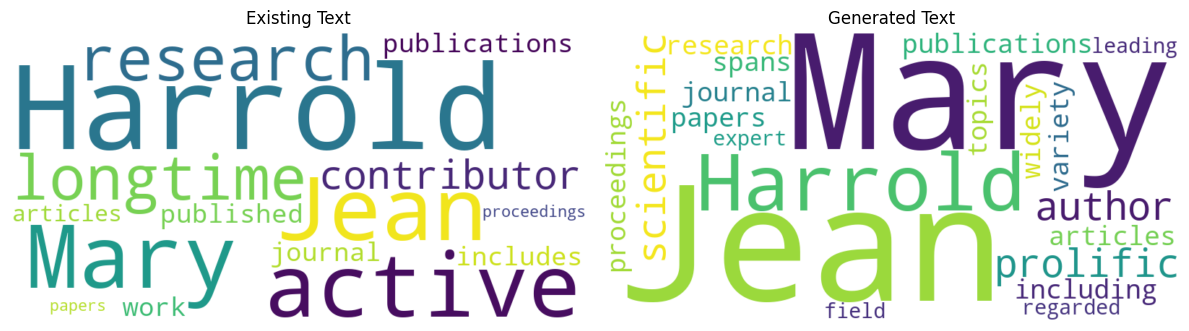

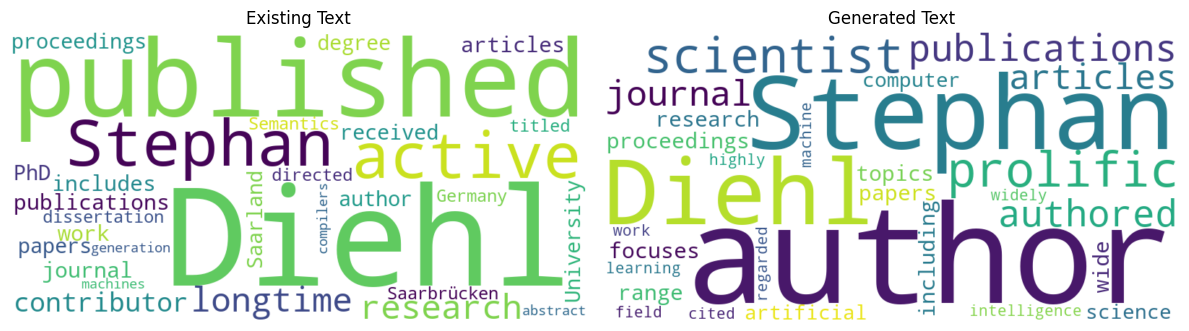

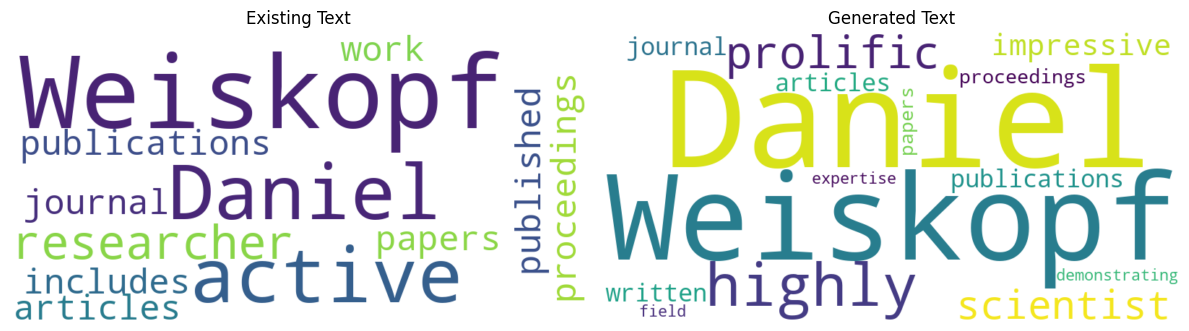

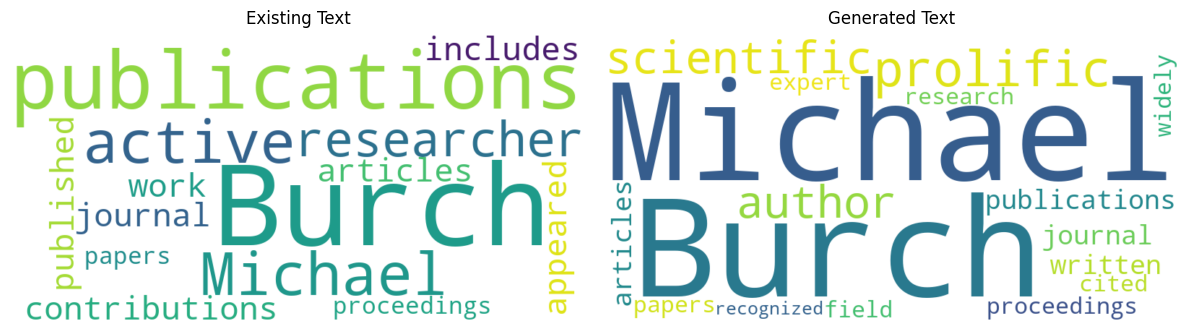

In [11]:


# Extract the existing and generated texts from the JSON data
for entry in data:
    existing_texts.append(entry['existing_text'])
    generated_texts.append(entry['generated_text1'])

# Generate word clouds for each pair of texts
for i in range(len(existing_texts)):
    existing_text = existing_texts[i]
    generated_text = generated_texts[i]

    # Generate word cloud for the existing text
    existing_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(existing_text)

    # Generate word cloud for the generated text
    generated_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(generated_text)

    # Plot the word clouds
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(existing_wordcloud, interpolation='bilinear')
    axes[0].set_title('Existing Text')
    axes[0].axis('off')

    axes[1].imshow(generated_wordcloud, interpolation='bilinear')
    axes[1].set_title('Generated Text')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

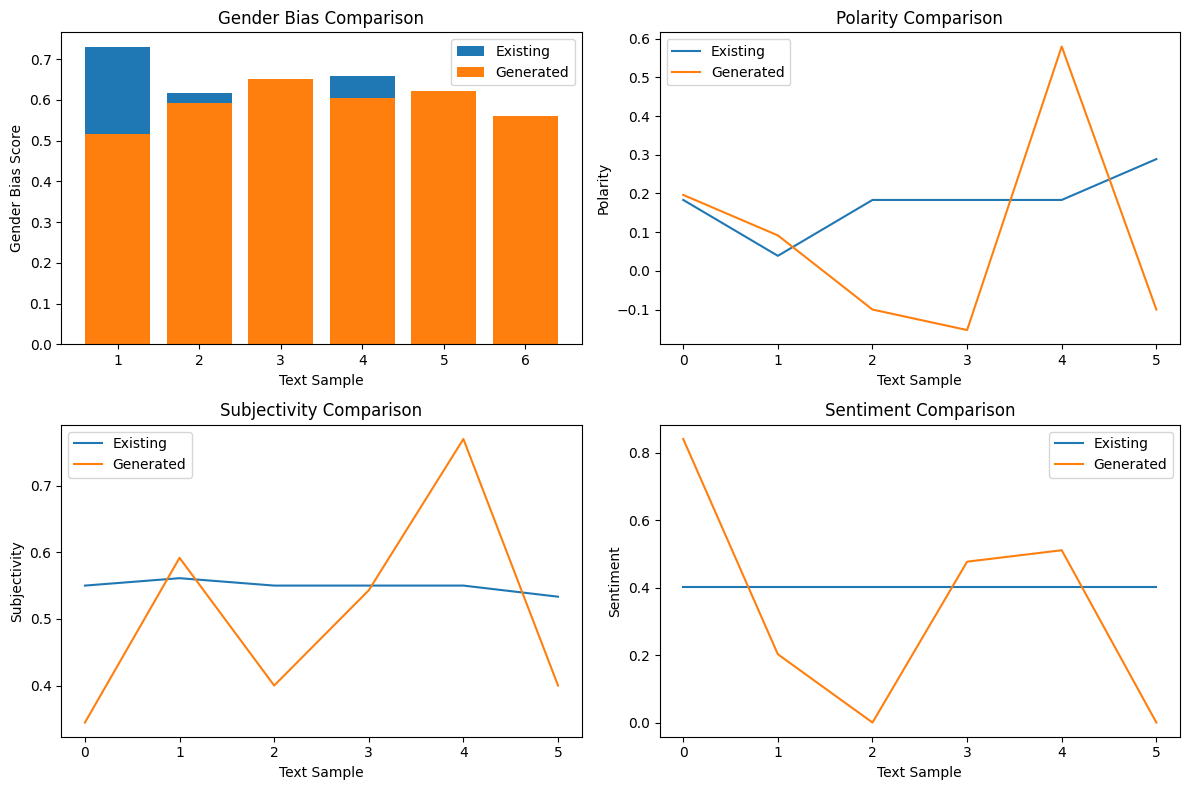

In [12]:

# Step 2: Perform Gender Bias Detection
def detect_gender_bias(text):
    # Load the gender bias detection model (e.g., BERT or GPT-3) and tokenize the input
    model = pipeline('text-classification', model='bert-base-uncased')
    result = model(text)[0]  # Assuming single-text classification
    label = result['label']
    score = result['score']
    return label, score

existing_gender_bias = [detect_gender_bias(text) for text in existing_texts]
generated_gender_bias = [detect_gender_bias(text) for text in generated_texts]

# Step 3: Perform Tone Detection
def detect_tone(text):
    # Using TextBlob
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Using VaderSentiment
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)

    return polarity, subjectivity, sentiment

existing_tones = [detect_tone(text) for text in existing_texts]
generated_tones = [detect_tone(text) for text in generated_texts]

# Step 4: Visualize the Metrics
existing_polarity = [tone[0] for tone in existing_tones]
generated_polarity = [tone[0] for tone in generated_tones]

existing_subjectivity = [tone[1] for tone in existing_tones]
generated_subjectivity = [tone[1] for tone in generated_tones]

existing_sentiment = [tone[2]['compound'] for tone in existing_tones]
generated_sentiment = [tone[2]['compound'] for tone in generated_tones]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Gender Bias
axes[0, 0].bar(range(len(existing_gender_bias)), [score for _, score in existing_gender_bias], label='Existing')
axes[0, 0].bar(range(len(generated_gender_bias)), [score for _, score in generated_gender_bias], label='Generated')
axes[0, 0].set_xticks(range(len(existing_gender_bias)))
axes[0, 0].set_xticklabels(range(1, len(existing_gender_bias) + 1))
axes[0, 0].set_xlabel('Text Sample')
axes[0, 0].set_ylabel('Gender Bias Score')
axes[0, 0].set_title('Gender Bias Comparison')
axes[0, 0].legend()

# Polarity
axes[0, 1].plot(existing_polarity, label='Existing')
axes[0, 1].plot(generated_polarity, label='Generated')
axes[0, 1].set_xlabel('Text Sample')
axes[0, 1].set_ylabel('Polarity')
axes[0, 1].set_title('Polarity Comparison')
axes[0, 1].legend()

# Subjectivity
axes[1, 0].plot(existing_subjectivity, label='Existing')
axes[1, 0].plot(generated_subjectivity, label='Generated')
axes[1, 0].set_xlabel('Text Sample')
axes[1, 0].set_ylabel('Subjectivity')
axes[1, 0].set_title('Subjectivity Comparison')
axes[1, 0].legend()

# Sentiment
axes[1, 1].plot(existing_sentiment, label='Existing')
axes[1, 1].plot(generated_sentiment, label='Generated')
axes[1, 1].set_xlabel('Text Sample')
axes[1, 1].set_ylabel('Sentiment')
axes[1, 1].set_title('Sentiment Comparison')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


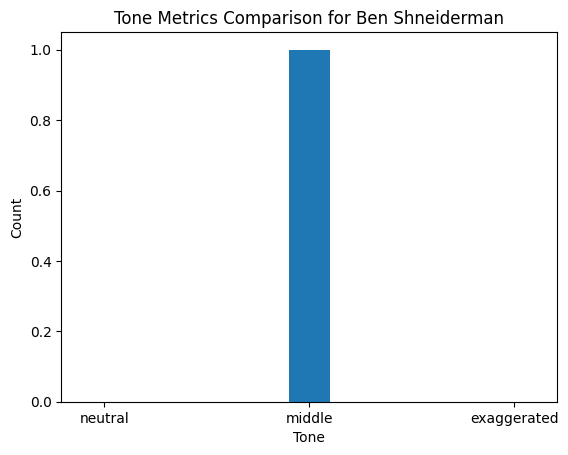

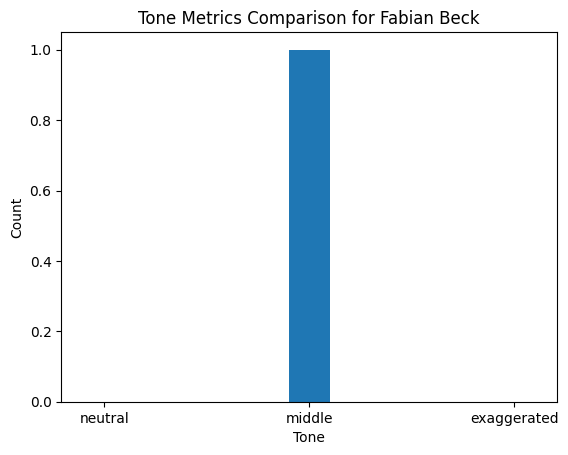

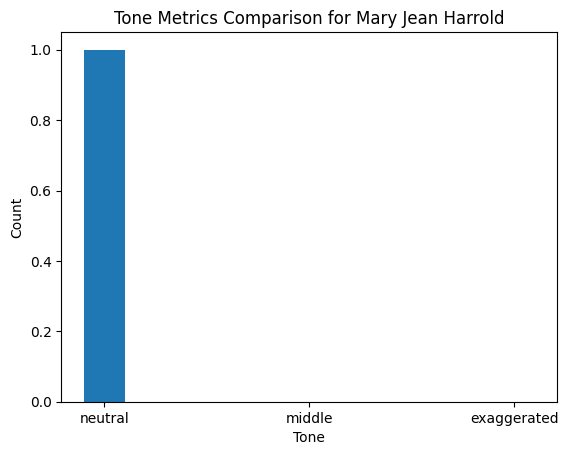

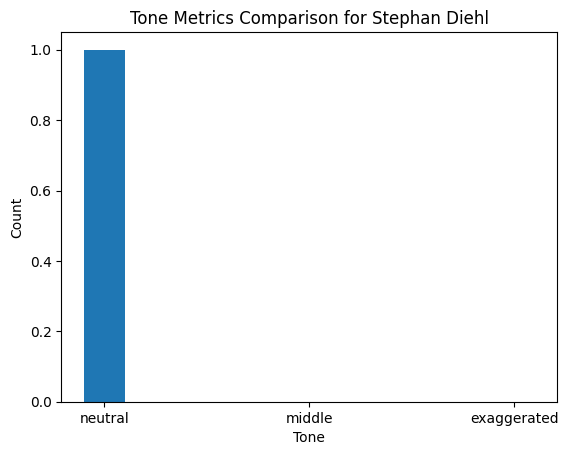

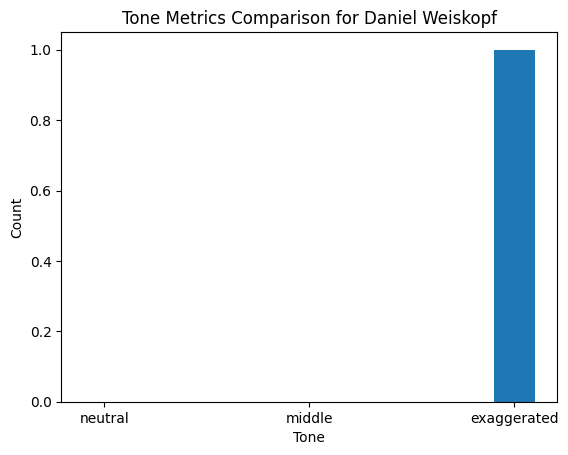

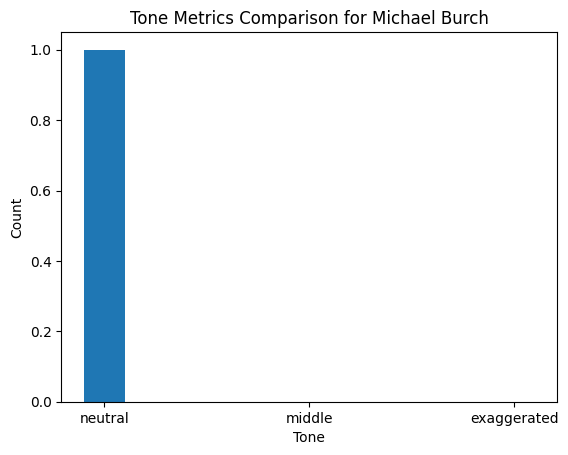

In [13]:


entry_names = [entry['name'] for entry in data]
existing_texts = [entry['existing_text'] for entry in data]
generated_texts = [entry['generated_text1'] for entry in data]

# Step 2: Define Tone Ranges
tone_ranges = {
    'neutral': (0.0, 0.2),
    'middle': (0.2, 0.4),
    'exaggerated': (0.4, 1.0)
}

# Step 3: Calculate Tone Metric for Each Entry
tone_metrics = []
for existing_text, generated_text in zip(existing_texts, generated_texts):
    existing_blob = TextBlob(existing_text)
    generated_blob = TextBlob(generated_text)

    existing_polarity = existing_blob.sentiment.polarity
    generated_polarity = generated_blob.sentiment.polarity

    tone_metric = None
    for tone, (lower, upper) in tone_ranges.items():
        if existing_polarity >= lower and existing_polarity < upper:
            tone_metric = tone
            break

    if generated_polarity >= upper:
        tone_metric = 'exaggerated'
    elif generated_polarity >= lower:
        tone_metric = 'middle'
    elif generated_polarity < lower:
        tone_metric = 'neutral'

    tone_metrics.append(tone_metric)

# Step 4: Count Tone Metrics for Each Entry
unique_tones = list(tone_ranges.keys())
counts_per_entry = []

for entry in entry_names:
    entry_counts = [tone_metrics[i] for i in range(len(entry_names)) if entry_names[i] == entry]
    counts = [entry_counts.count(tone) for tone in unique_tones]
    counts_per_entry.append(counts)

# Step 5: Visualize the Tone Metrics
bar_width = 0.2
index = np.arange(len(unique_tones))

for i, entry in enumerate(entry_names):
    fig, ax = plt.subplots()
    ax.bar(index, counts_per_entry[i], bar_width)
    ax.set_xlabel('Tone')
    ax.set_ylabel('Count')
    ax.set_title(f'Tone Metrics Comparison for {entry}')
    ax.set_xticks(index)
    ax.set_xticklabels(unique_tones)
    plt.show()
